In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

In [ ]:
import catboost as catb

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [ ]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [ ]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

Пути к файлам

In [ ]:
TRAIN_DATASET_PATH = 'C:\course_project\course_project_train.csv'
TEST_DATASET_PATH = 'C:\course_project\course_project_test.csv'

###Загрузка данных

In [ ]:
df_test = pd.read_csv(TEST_DATASET_PATH)

In [ ]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [ ]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

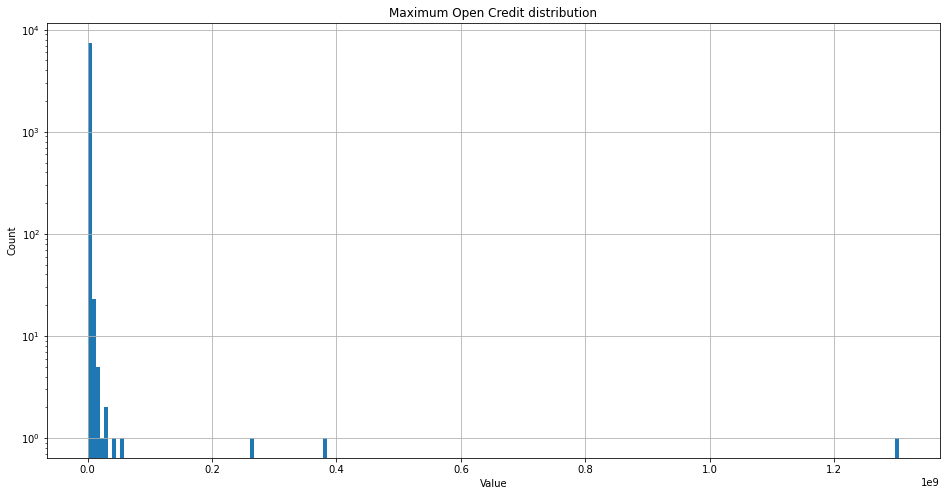

In [ ]:
plt.figure(figsize = (16, 8))

df_train['Maximum Open Credit'].hist(bins=200)
plt.yscale(value='log')
plt.ylabel('Count')
plt.xlabel('Value')

plt.title('Maximum Open Credit distribution')
plt.show()

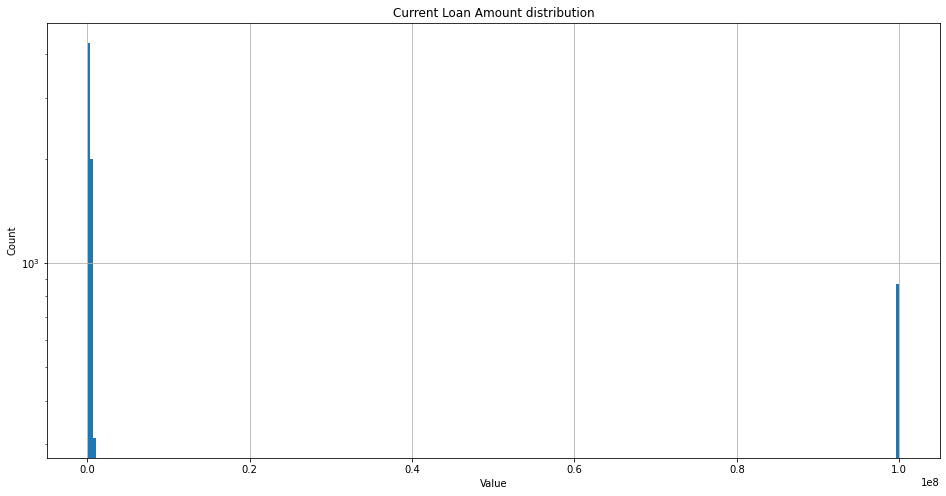

In [ ]:
plt.figure(figsize = (16, 8))

df_train['Current Loan Amount'].hist(bins=300)
plt.yscale(value='log')
plt.ylabel('Count')
plt.xlabel('Value')

plt.title('Current Loan Amount distribution')
plt.show()

In [ ]:
df_train['Credit Score'].sort_values().unique()

array([ 585.,  586.,  588.,  589.,  590.,  591.,  593.,  594.,  597.,
        598.,  599.,  601.,  602.,  604.,  606.,  607.,  608.,  609.,
        610.,  611.,  612.,  613.,  614.,  615.,  616.,  617.,  618.,
        619.,  620.,  621.,  622.,  624.,  625.,  626.,  627.,  628.,
        629.,  630.,  631.,  632.,  633.,  634.,  635.,  636.,  637.,
        638.,  639.,  640.,  642.,  643.,  644.,  645.,  646.,  647.,
        648.,  649.,  650.,  651.,  652.,  653.,  654.,  655.,  656.,
        657.,  658.,  659.,  660.,  661.,  662.,  663.,  664.,  665.,
        666.,  667.,  668.,  669.,  670.,  671.,  672.,  673.,  674.,
        675.,  676.,  677.,  678.,  679.,  680.,  681.,  682.,  683.,
        684.,  685.,  686.,  687.,  688.,  689.,  690.,  691.,  692.,
        693.,  694.,  695.,  696.,  697.,  698.,  699.,  700.,  701.,
        702.,  703.,  704.,  705.,  706.,  707.,  708.,  709.,  710.,
        711.,  712.,  713.,  714.,  715.,  716.,  717.,  718.,  719.,
        720.,  721.,

###Класс подготовки исходных данных

In [ ]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.max_credit_mean = None
        self.cur_loan_amount_mean = None

        
    def fit(self, X):
        """Сохранение статистик"""       
        self.medians = X.median()
        self.max_credit_mean = round(X.loc[X['Maximum Open Credit'] <= 20000000.0, 'Maximum Open Credit'].mean())
        self.cur_loan_amount_mean = round(X.loc[X['Current Loan Amount'] != 99999999.0, 'Current Loan Amount'].mean())
        
    
    def transform(self, X):
        """Трансформация данных"""

        # Maximum Open Credit. Значения больше 20 млн. принимаем за выбросы, заменяем на среднее
        X.loc[X['Maximum Open Credit'] > 20000000.0, 'Maximum Open Credit'] = self.max_credit_mean
        
        #Current Loan Amount. Значения равные 99999999.0 принимаем за выбросы, заменяем на среднее
        X.loc[X['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = self.cur_loan_amount_mean

        #Credit Score. 
        #Т.к. значения кредитного скоринга должны быть не более 999, считаем, что значениям больше 999 был некорректно добавлен лишний десяток
        X['Credit Score_outlier'] = 0
        X.loc[X['Credit Score'] > 999, 'Credit Score_outlier'] = 1
        X.loc[X['Credit Score'] > 999, 'Credit Score'] = X.loc[X['Credit Score'] > 999, 'Credit Score'] / 10

        X['Credit Score_nan'] = 0
        X.loc[X['Credit Score'].isna(), 'Credit Score_nan'] = 1
        X.loc[X['Credit Score'].isna(), 'Credit Score'] = self.medians['Credit Score']

        #Annual Income
        X['Annual Income_nan'] = 0
        X.loc[X['Annual Income'].isna(), 'Annual Income_nan'] = 1
        X.loc[X['Annual Income'].isna(), 'Annual Income'] = self.medians['Annual Income']
        
        #Months since last delinquent
        X['Months since last delinquent_nan'] = 0
        X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent_nan'] = 1
        X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent'] = self.medians['Months since last delinquent']

        #Bankruptcies
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies'] = self.medians['Bankruptcies']
        
        X.fillna(self.medians, inplace=True)
        
        return X

### Класс генерации новых признаков

In [ ]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        
        self.binary_to_num_years = None
        self.binary_to_num_purpose = None

        
    def fit(self, X):
        
        X = X.copy()
        
        # Binary features. Задаем текстовым значениям соответствующие числовые значения
        self.binary_to_num_years = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5, \
                                    '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}
        
        df = X
        df['Purpose'] = df['Purpose'].astype('category')
        df['Purpose_num'] = df['Purpose'].cat.codes
        self.binary_to_num_purpose = df.loc[:, ['Purpose', 'Purpose_num']].groupby('Purpose')['Purpose_num'].max().to_dict()   
   
                
    def transform(self, X):
        
        #Home Ownership
        X = pd.get_dummies(X, columns=['Home Ownership'])
        
        #Years in current job
        X['Years in current job'] = X['Years in current job'].map(self.binary_to_num_years)
        
        X['Years in current job_nan'] = 0
        X.loc[X['Years in current job'].isna(), 'Years in current job_nan'] = 1
        X.loc[X['Years in current job'].isna(), 'Years in current job'] = X['Years in current job'].median()
        
        X = self.years_in_groups(X)

        #Purpose
        X['Purpose'] = X['Purpose'].map(self.binary_to_num_purpose)
        X['Purpose'] = X['Purpose'].astype('category')   

        return X


    def years_in_groups(self, X):
        bins = [-1, 0, 3, 6, 9, 10]
        X['Groups of years in job_cat'] = pd.cut(X['Years in current job'], bins=bins, labels=False)

        X['Groups of years in job_cat'].fillna(-1, inplace=True)
        X['Groups of years in job_cat'] = X['Groups of years in job_cat'].astype('category')

        return X


###Отбор признаков

In [ ]:
feature_names = ['Annual Income', 'Years in current job', 'Tax Liens',
                'Number of Open Accounts', 'Years of Credit History',
                'Maximum Open Credit', 'Number of Credit Problems',
                'Months since last delinquent', 'Bankruptcies', 'Purpose',
                'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                'Credit Score']

new_feature_names = ['Credit Score_outlier', 'Credit Score_nan',
                    'Annual Income_nan', 'Months since last delinquent_nan',
                    'Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage',
                    'Home Ownership_Own Home', 'Home Ownership_Rent',
                    'Years in current job_nan', 'Groups of years in job_cat']

target_name = 'Credit Default'

###Разбиение на test и train

In [ ]:
X = df_train.drop(columns=target_name)
y = df_train[target_name]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

###Балансировка целевой переменной

In [ ]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
df_balanced[target_name].value_counts()

0    3611
1    2828
Name: Credit Default, dtype: int64

In [ ]:
X_train = df_balanced.drop(columns=target_name)
y_train = df_balanced[target_name]

###Подготовка данных

In [ ]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
df_test = preprocessor.transform(df_test)

X_train.shape, X_valid.shape, df_test.shape

((6439, 20), (2475, 20), (2500, 20))

###Генерация новых признаков

In [ ]:
features_gen = FeatureGenetator()
features_gen.fit(X_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
df_test = features_gen.transform(df_test)

X_train.shape, X_valid.shape, df_test.shape

((6439, 25), (2475, 25), (2500, 25))

In [ ]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
df_test = df_test[feature_names + new_feature_names]

In [ ]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0, 0)

###Построение модели

In [ ]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train, cat_features=[9, 23])

y_train_pred = model_catb.predict(X_train)
y_valid_pred = model_catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      3611
           1       0.93      0.84      0.88      2828

    accuracy                           0.90      6439
   macro avg       0.91      0.90      0.90      6439
weighted avg       0.91      0.90      0.90      6439

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1776
           1       0.54      0.46      0.49       699

    accuracy                           0.74      2475
   macro avg       0.67      0.65      0.66      2475
weighted avg       0.72      0.74      0.73      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1501  275
1                379  320


Подбор гиперпараметров

In [ ]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

In [ ]:
params = {'n_estimators':[400, 450, 500, 550], 
          'max_depth':[2, 3, 4, 5],
          'learning_rate':[0.01, 0.03, 0.04, 0.05]}

In [ ]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [ ]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train, cat_features=[9, 23])

CPU times: user 6.71 s, sys: 400 ms, total: 7.11 s
Wall time: 1min 35s


In [ ]:
rs.best_params_

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500}

In [ ]:
rs.best_score_

0.6530784790261946

Обучение и оценка финальной модели

In [ ]:
model_catb = catb.CatBoostClassifier(n_estimators=500, max_depth=2, learning_rate=0.05, 
                                     silent=True, random_state=21)
model_catb.fit(X_train, y_train, cat_features=[9, 23])

y_train_pred = model_catb.predict(X_train)
y_valid_pred = model_catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      3611
           1       0.76      0.59      0.66      2828

    accuracy                           0.74      6439
   macro avg       0.74      0.72      0.72      6439
weighted avg       0.74      0.74      0.73      6439

TEST

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1776
           1       0.53      0.49      0.51       699

    accuracy                           0.73      2475
   macro avg       0.67      0.66      0.66      2475
weighted avg       0.73      0.73      0.73      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1470  306
1                354  345


Важность признаков

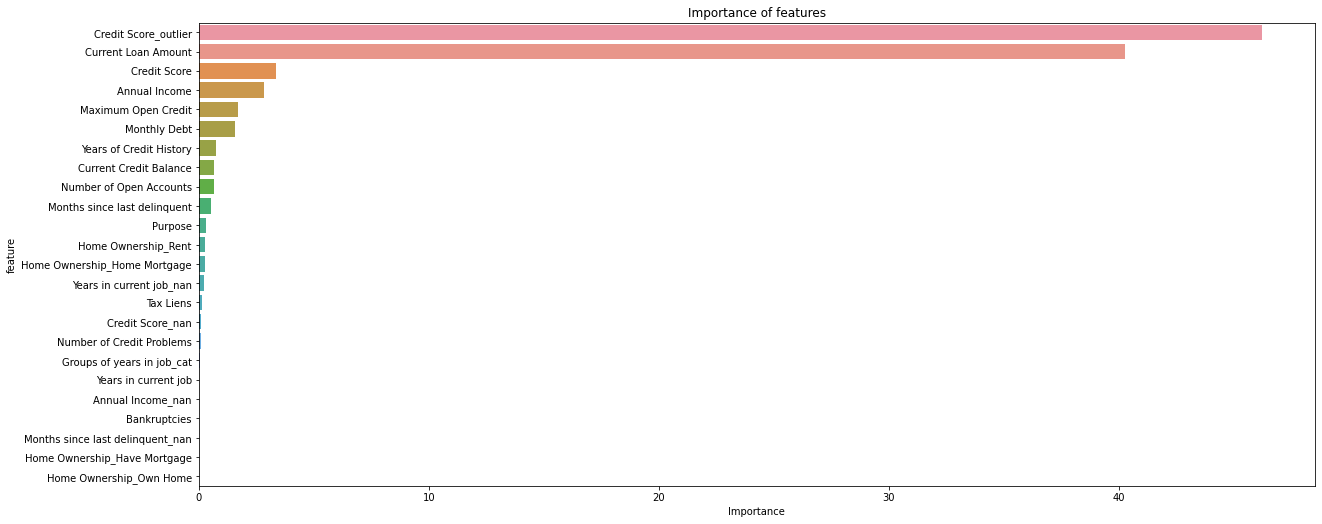

In [ ]:
important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=15)

###Прогнозирование на тестовом датасете

In [ ]:
predictions = model_catb.predict(df_test)
predictions

array([0, 1, 1, ..., 1, 0, 1])

In [ ]:
submit = pd.DataFrame({'Credit Default': predictions}, columns=['Credit Default'])
submit

,Credit Default
0,0
1,1
2,1
3,0
4,0
...,...
2495,0
2496,1
2497,1
2498,0


In [ ]:
submit.to_csv('C:\course_project\VShilling_predictions.csv')